# FacialRecognizer Demo

## 1) Introduction

In this jupyter notebook we showcase the facial recognition system and classification model created with Statistical Learning and Deep Learning techniques.

Firstly, we set up the image dataset and then we briefly explain the techniques we implemented in Python.

In [1]:
# Install libraries
!python3 -m pip install -r requirements.txt --quiet

# Download images
!python3 set_up_data.py

Dataset has been successfully downloaded!
Train and test partitions were created!
Validation partition has been generated!


We split the dataset into three partitions: training, validation and test. Some individuals are excluded from the training set as to simulate new faces that should not be assigned to any of the training labels.

In [2]:
import os
import random

import numpy as np
import polars as pl

from sklearn.preprocessing import StandardScaler

from PIL import Image
import matplotlib.pyplot as plt

from stats.pca import PCA
from stats.fisherfaces import FisherFaces
from controllers.data_images import get_image_matrix

Let's check the distribution of each partition

In [3]:
# We can check the distribution of the partitions
total = 0
for partition in ['train', 'validation', 'test']:
    n_images = len(os.listdir(f'data/{partition}'))
    total += n_images
    print(f'There are {n_images} images in {partition}')
print(f'Total number of images: {total}')

There are 1800 images in train
There are 376 images in validation
There are 883 images in test
Total number of images: 3059


Now we show a sample of images

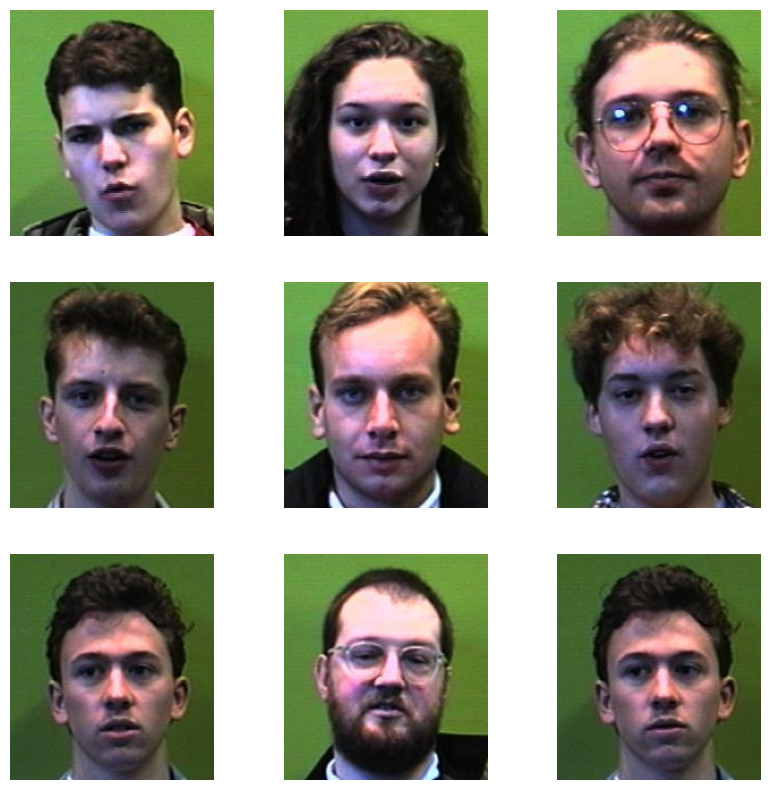

In [4]:
# Get a random sample from training partition
train_images = os.listdir('data/train')
random_sample = random.sample(population=train_images, k=9)

# Plot a grid of images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = Image.open(f'data/train/{random_sample[i]}')
    ax.imshow(np.array(img))
    ax.axis('off')
plt.show()

## 2) Objectives and Challenges

We aim to create a smart system that automatically identifies whether an individual belongs to our databse or not. In case they do, we would also like to know its identity. 

We propose two ways to achieve this goal: Statistical Learning and Deep Learning. The former requires feature engineering and a set of assumptions on the joint distribution of the data, whereas the latter does away with most statistical restrictions at the price of expensive computations.

## 3) Eigenfaces

Let $\pmb{\Gamma}_i$ be the i-th image of our dataset. By extracting and flattening the RGB color channel values of each image we end up with $p$ pixels. Note that there are $m$ training images in total.

Thus, $\pmb{\Gamma}_i \in \mathbb{R}^p$ and so the training set may be expressed as $\pmb{\Gamma} = \left[\pmb{\Gamma}_1 \, \pmb{\Gamma}_2 \, \dots \, \pmb{\Gamma}_m \right], \quad \pmb{\Gamma} \in \mathbb{R}^{p \times m}$

We wish to represent the joint distribution of $\pmb{\Gamma}$ using PCA (Principal Component Analysis). The fundamental concept is that a set of face images can be effectively reconstructed by saving a limited number of weights for each face along with a small group of basic images, known as **eigenfaces**. Consequently, an efficient facial recognition system could be built from these characteristic features.

Let the average face and the face spread be defined by:

\begin{align*}
    \pmb{\Psi} = \frac{1}{m}\sum_{j=1}^m \pmb{\Gamma}_j, \quad \pmb{\Omega} = \frac{1}{m-1} \sum_{j=1}^m \left(\pmb{\Gamma}_j - \pmb{\Psi} \right)^2
\end{align*}

It is necessary to work with centered image data to retrieve the characteristic features, so we scale the training set:

$$\pmb{\Phi}_i = \left(\pmb{\Gamma}_i - \pmb{\Psi} \right) \oslash \sqrt{\pmb{\Omega}}, \quad \quad \pmb{\Phi} = \left[\pmb{\Phi}_1 \, \pmb{\Phi}_2 \, \dots \, \pmb{\Phi}_m \right]$$

The set of orthonormal vectors $\pmb{\sigma}_k$ that best describes the distribution of the images are retrieved from the covariance matrix: $\textbf{C} = \pmb{\Phi}\pmb{\Phi}'$.

However, note that $\textbf{C} \in \mathbb{R}^{p \times p}$, where $p \gt \gt m$, so diagonalizing $\textbf{C}$ is computationally expensive (and oftentimes intractable). Nevertheless:

$$
\begin{align*}
\pmb{\Phi}'\pmb{\Phi}\pmb{v}_i & = \mu_i\pmb{v}_i \\
\underbrace{\pmb{\Phi}\pmb{\Phi}'}_{\textbf{C}}\pmb{\Phi}\pmb{v}_i &= \mu_i\pmb{\Phi}\pmb{v}_i
\end{align*}
$$

So $\pmb{\Phi}\pmb{v}_i$ are the eigenvectors of $\textbf{C} = \pmb{\Phi}\pmb{\Phi}'$.

It is then more efficient to construct $\pmb{L} = \pmb{\Phi}'\pmb{\Phi}$, diagonalize $\pmb{L}$, obtain its eigenvectors $\pmb{V} \in \mathbb{R}^{m \times m}$ and sort them by their eigenvalues, select the $m'$ largest eigenvalues $\left(m' \text{ columns of } \pmb{V}\right)$ and finally retrieve $\pmb{\tilde{V}} \in \mathbb{R}^{m \times m'}$.

That way we can obtain the eigenvectors of $\textbf{C}$ by $\pmb{\sigma} = \pmb{\Phi}\pmb{\tilde{V}}$, where $\pmb{\sigma} \in \mathbb{R}^{p \times m'}$, which Turck and Pentland (1991) call "eigenfaces".

Finally, we can project each original image into the "face space": $\pmb{\Theta} = \pmb{\sigma}'\pmb{\Phi}$, considerably reducing dimensionality as $\pmb{\Theta} \in \mathbb{R}^{m' \times m}$.

Below there is a sample image of an eigenface:

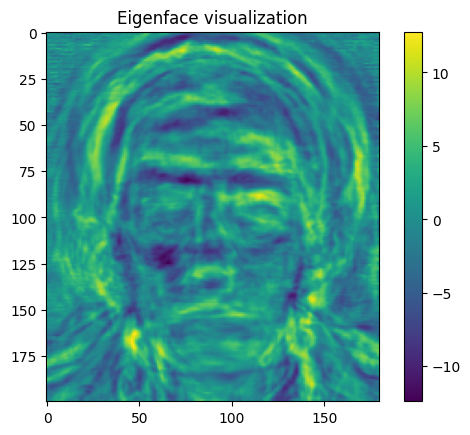

In [5]:
# Load training images and obtain an eigenface
df = get_image_matrix(get_sobel=True)
df_train = df.filter(pl.col('partition') == 'train')
pca = PCA(var_explained=0.95)
pca.fit(df_train.drop(df_train.columns[-2:]))
pca.visualize_eigenface(height=200, width=180)

This eigenface presents a reduction in pixel information, leading to a visual appearance that resembles a composite of various facial images. This effect highlights the principal components of facial features used in face recognition systems.

Let's explain the training procedure:

Given a new test image $\pmb{\Gamma}_k$ we scale it with training data: $\pmb{\Phi}_k = (\pmb{\Gamma}_k - \pmb{\Psi}) \oslash \sqrt{\pmb{\Omega}}$.

Then we project $\pmb{\Phi}_k$ into the "face space" with $\pmb{\Theta}_k = \pmb{\sigma}'\pmb{\Phi}_k$. 

In order to determine which class best defines the new test image (if any), we compute $d(\pmb{\Theta}, \pmb{\Theta}_k)$, where $d(·)$ is a statistical dissimilarity metric like the L2 norm, cosine distance, etc.

If $\text{min}\left\{d(\pmb{\Theta}, \pmb{\Theta}_k)\right\} \gt \varepsilon$, then the new test image is predicted not to belong to the training dataset. Otherwise, the majority vote of the $k$ nearest neighbors defined by the distance metric is the prediction. In order to avoid ties, we define $k$ such that it is odd. Notice that $\varepsilon$ is a threshold value specifically chosen for each statistical dissimilarity.

We select the hyperparameters $\{\varepsilon, v, k\}$ using Bayesian Optimization. The hyperparameter $v$ represents the percentage of variance explained in PCA.

We define the prior probability distributions as follows:

\begin{align*}
\varepsilon & \sim U[0.1, 0.2] \\
k & \sim U[1, 7] \\
v & \sim U[0.85, 0.95]
\end{align*}

After fitting the model with random samples of $\{\varepsilon, v, k\}$, we update the posterior probabilities of the hyperparameters by maximizing the expected improvement in accuracy.

In [6]:
!python3 train_eigenfaces.py

[I 2024-05-02 18:52:34,936] A new study created in memory with name: EigenFaces
[I 2024-05-02 18:53:05,427] Trial 0 finished with value: 0.8962765957446809 and parameters: {'n_neighbors': 3, 'threshold': 0.19507143064099164, 'var_explained': 0.9231993941811405}. Best is trial 0 with value: 0.8962765957446809.
[I 2024-05-02 18:53:28,527] Trial 1 finished with value: 0.8909574468085106 and parameters: {'n_neighbors': 5, 'threshold': 0.11560186404424366, 'var_explained': 0.8655994520336202}. Best is trial 0 with value: 0.8962765957446809.
[I 2024-05-02 18:53:53,163] Trial 2 finished with value: 0.8962765957446809 and parameters: {'n_neighbors': 1, 'threshold': 0.18661761457749354, 'var_explained': 0.9101115011743208}. Best is trial 0 with value: 0.8962765957446809.
[I 2024-05-02 18:54:21,729] Trial 3 finished with value: 0.8882978723404256 and parameters: {'n_neighbors': 5, 'threshold': 0.10205844942958026, 'var_explained': 0.9469909852161994}. Best is trial 0 with value: 0.89627659574468

## 4) Fisherfaces

For this classifier, we transposed the original image data matrix in a way that $\pmb{\Gamma} \in \mathbb{R}^{m \times p}$ for simplifying calculations. $\pmb{\Theta}$ is then used to calculate two covariance matrices: the within-class covariance matrix $\textbf{S}_W$, and the between-class covariance matrix $\textbf{S}_B$.

Let the mean vector of the $i$-th class and the mean vector of $\pmb{\Theta}$ be defined as:

$$\pmb{\bar{\Theta}}_i = \frac{1}{n_i}\sum_{i \in c_i}\pmb{\Theta}_n, \quad \pmb{\bar{\Theta}} = \frac{1}{m} \sum_{j=1}^m \pmb{\Theta}_j$$

We wish to maximize the separation between the classes while also minimizing the variance inside each class.

The within-class and between-class variances are expressed as:

$$
\textbf{S}_W = \sum_{i=1}^k \sum_{j \in c_i} \left(\pmb{\Theta}_j - \pmb{\bar{\Theta}}_i\right)\left(\pmb{\Theta}_j - \pmb{\bar{\Theta}}_i\right)' \,, \quad \, \textbf{S}_B = \sum_{i=1}^k n_i\left(\pmb{\bar{\Theta}}_i - \pmb{\bar{\Theta}}\right)\left(\pmb{\bar{\Theta}}_i - \pmb{\bar{\Theta}}\right)'
$$

This optimization problem leads to the $k - 1$ largest eigenvalues of $\textbf{S}_W^{-1}\textbf{S}_B$. We only keep the $m''$ (noting that $m'' \lt \lt m'$) eigenvectors that contribute the most to represent images (up to some fixed percentage of cumulative explained variance).
Mathematically: $\pmb{\Lambda} = \text{eigen}\left(\textbf{S}_W^{-1}\textbf{S}_B\right)$, where $\pmb{\Lambda} \in \mathbb{R}^{m' \times m''}$.

Then we project $\pmb{\sigma}$ into the new fisher face space: $\pmb{\Upsilon} = \pmb{\sigma}\pmb{\Lambda}$, further reducing dimensionality since $\pmb{\Upsilon} \in \mathbb{R}^{m \times m''}$.

A sample fisherface is shown below:

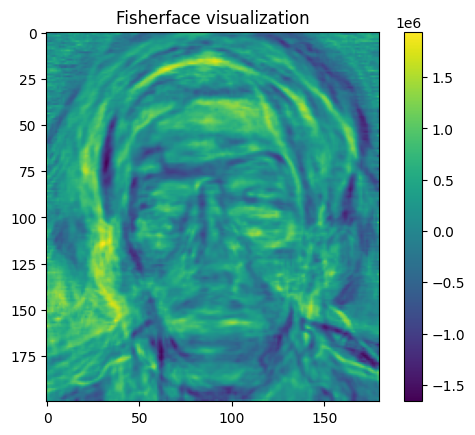

In [7]:
# Scale training images
scaler = StandardScaler()
scaled_images = scaler.fit_transform(
    df_train.drop(df_train.columns[-2:])
)

# Get LDA coefficients and projection
fisher = FisherFaces(
    n_neighbors=3, 
    var_explained=0.9, 
    threshold=0.001, 
    ignore_warnings=True
)
fisher.fit(df_train.drop('partition'))

# Select a fisherface
projection = scaled_images.T @ fisher.fisher_projection
image = projection.real.T[23, :].reshape(200, 180)
plt.imshow(image, cmap='viridis')
plt.title('Fisherface visualization')
plt.colorbar()
plt.show()

After this, we proceed to compare each new projection of validation / test images $\pmb{\Upsilon}_k$ with $\pmb{\Upsilon}$ through statistical distances, fixing a threshold $\varepsilon$ to discern whether the new photo truly belongs to the database or not. 

Again, Bayesian optimization is used to select the optimal hyperparameters.

In [8]:
!python3 train_fisherfaces.py

[I 2024-05-02 18:57:46,042] A new study created in memory with name: FisherFaces
[I 2024-05-02 18:58:16,534] Trial 0 finished with value: 0.9920212765957447 and parameters: {'n_neighbors': 3, 'threshold': 0.19507143064099164, 'var_explained': 0.9231993941811405}. Best is trial 0 with value: 0.9920212765957447.
[I 2024-05-02 18:58:39,658] Trial 1 finished with value: 0.9867021276595744 and parameters: {'n_neighbors': 5, 'threshold': 0.11560186404424366, 'var_explained': 0.8655994520336202}. Best is trial 0 with value: 0.9920212765957447.
[I 2024-05-02 18:59:05,953] Trial 2 finished with value: 0.9946808510638298 and parameters: {'n_neighbors': 1, 'threshold': 0.18661761457749354, 'var_explained': 0.9101115011743208}. Best is trial 2 with value: 0.9946808510638298.
[I 2024-05-02 18:59:37,053] Trial 3 finished with value: 0.973404255319149 and parameters: {'n_neighbors': 5, 'threshold': 0.10205844942958026, 'var_explained': 0.9469909852161994}. Best is trial 2 with value: 0.99468085106382

This facial recognizer achieves higher accuracy on test data than the previous Eigenfaces method.

It makes sense since LDA focuses on maximizing the spread between classes and minimizing the within-class variance.

## 5) Deep Learning

Deep Learning has significantly advanced the field of facial recognition, offering superior performance over traditional statistical learning methods. The architecture of choice for initiating this discussion is LeNet-5, a pioneering convolutional neural network that has proven effective in image recognition tasks.

Convolutional Neural Networks (CNNs), particularly, excel in handling high-dimensional data like images. Unlike traditional statistical learning that often requires manual feature extraction, CNNs automatically learn hierarchies of features through multiple layers of processing. This capability enables them to capture complex patterns in facial features, which are crucial for accurate recognition.

LeNet-5 consists of several layers that transform the input image into feature maps and ultimately into classification outputs. Let $\pmb{X} \in \mathbb{R}^{h \times w}$ denote the input image. The transformation through LeNet-5 can be mathematically described as follows:

\begin{align*}
\text{C1: Convolution Layer} & : \pmb{X} * \pmb{K}_{c1} + b_{c1} \rightarrow \pmb{A}_{c1} \\
\text{S2: Subsampling Layer} & : \text{downsample}(\pmb{A}_{c1}) \rightarrow \pmb{A}_{s2} \\
\text{C3: Convolution Layer} & : \pmb{A}_{s2} * \pmb{K}_{c3} + b_{c3} \rightarrow \pmb{A}_{c3} \\
\text{S4: Subsampling Layer} & : \text{downsample}(\pmb{A}_{c3}) \rightarrow \pmb{A}_{s4} \\
\text{C5: Convolution Layer} & : \pmb{A}_{s4} * \pmb{K}_{c5} + b_{c5} \rightarrow \pmb{A}_{c5} \\
\text{F6: Fully Connected Layer} & : \text{flatten}(\pmb{A}_{c5}) \cdot \pmb{W}_{f6} + b_{f6} \rightarrow \pmb{A}_{f6} \\
\text{OUTPUT: Softmax Layer} & : \text{softmax}(\pmb{A}_{f6}) \rightarrow \pmb{Y}
\end{align*}

where $\pmb{K}_{ci}$, $\pmb{W}_{f6}$, and $b$ denote the convolutional kernels, weights of the fully connected layer, and biases respectively. Each layer serves to extract and refine features, adapting to complex facial structures crucial for recognition tasks.

In [12]:
!python3 train_lenet.py

Epoch 1:
Training loss: 8.0268
Epoch 2:
Training loss: 0.1516
Epoch 3:
Training loss: 0.0075
Epoch 4:
Training loss: 0.0034
Epoch 5:
Training loss: 0.0032
Epoch 6:
Training loss: 0.0002
Epoch 7:
Training loss: 0.0001
Epoch 8:
Training loss: 0.0001
Epoch 9:
Training loss: 0.0
Epoch 10:
Training loss: 0.0
Accuracy on test data: 99.399%


The accuracy attained by LeNet-5 is higher than the Statistical Learning techniques.

Statistical learning methods, such as Linear Discriminant Analysis (LDA), focus on linear relationships and are often limited by the assumption of linear separability of classes in the feature space. In contrast, Deep Learning leverages non-linear transformations for a more robust feature extraction, significantly enhancing the discrimination power in complex visual tasks like facial recognition. 

The primary advantage of employing LeNet-5 in facial recognition is its ability to learn feature representations at various levels of abstraction, allowing it to outperform models that rely on manually engineered features or shallow learning architectures.

Thus, Deep Learning not only simplifies the preprocessing steps required in facial recognition but also improves accuracy and adaptability across diverse facial datasets.